In [6]:
import os
import numpy as np

In [7]:
folder = r"C:\Users\revan\OneDrive\Desktop\IMS_dataset\1st_test"

In [1]:
files = sorted(os.listdir(folder))


NameError: name 'os' is not defined

In [9]:
for f in files[:5]:
    print(repr(f))


'2003.10.22.12.06.24'
'2003.10.22.12.09.13'
'2003.10.22.12.14.13'
'2003.10.22.12.19.13'
'2003.10.22.12.24.13'


In [11]:
data = np.loadtxt(os.path.join(folder, files[0]))
print(data.shape)  # Should be (20480, 8) for 1st_test

(20480, 8)


In [12]:
def extract_features(signal):
    return [
        np.mean(signal),
        np.std(signal),
        np.max(signal),
        np.min(signal),
        np.sqrt(np.mean(signal**2)),  # RMS
        scipy.stats.kurtosis(signal),
        scipy.stats.skew(signal)
    ]

import scipy.stats

features = []
for file in files:
    data = np.loadtxt(os.path.join(folder, file))
    feats = [extract_features(data[:, ch]) for ch in range(data.shape[1])]
    features.append(np.concatenate(feats))


In [13]:
import numpy as np

def load_ims_file(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    data = [np.fromstring(line.strip(), sep=' ') for line in lines]
    return np.array(data)  # shape: (n_channels, 20480)

# Load the first file
file_path = os.path.join(folder, files[0])
data = load_ims_file(file_path)
print("Data shape:", data.shape)
print("First 10 samples, channel 0:", data[0, :10])


Data shape: (20480, 8)
First 10 samples, channel 0: [-0.022 -0.039 -0.183 -0.054 -0.105 -0.134 -0.129 -0.142]


In [14]:
import numpy as np  #feqature extraction pipeline
import scipy.stats

def extract_features(signal):
    """Extract features from 1D vibration signal"""
    return {
        'rms': np.sqrt(np.mean(signal**2)),
        'kurtosis': scipy.stats.kurtosis(signal),
        'peak': np.max(np.abs(signal)),
        'crest_factor': np.max(np.abs(signal)) / np.sqrt(np.mean(signal**2)),
        'skewness': scipy.stats.skew(signal)
    }

# Process all channels in one file
features_per_file = []
for ch in range(data.shape[1]):
    channel_data = data[:, ch]
    features = extract_features(channel_data)
    features_per_file.append(features)


In [16]:
all_features = []  #batch processing for entire dataset

for file_name in files:
    file_path = os.path.join(folder, file_name)
    data = load_ims_file(file_path)  # Your loader function
    
    file_features = []
    for ch in range(data.shape[1]):
        ch_features = extract_features(data[:, ch])
        file_features.append(ch_features)
    
    all_features.append(file_features)


In [17]:
import pandas as pd #Timeline construction
from datetime import datetime, timedelta

# Convert filenames to timestamps
timestamps = [datetime.strptime(f, "%Y.%m.%d.%H.%M.%S") for f in files]

# Create time-aware feature matrix
df = pd.DataFrame({
    'timestamp': timestamps,
    'features': all_features
}).sort_values('timestamp')

# Calculate time since start
df['hours_since_start'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds() / 3600


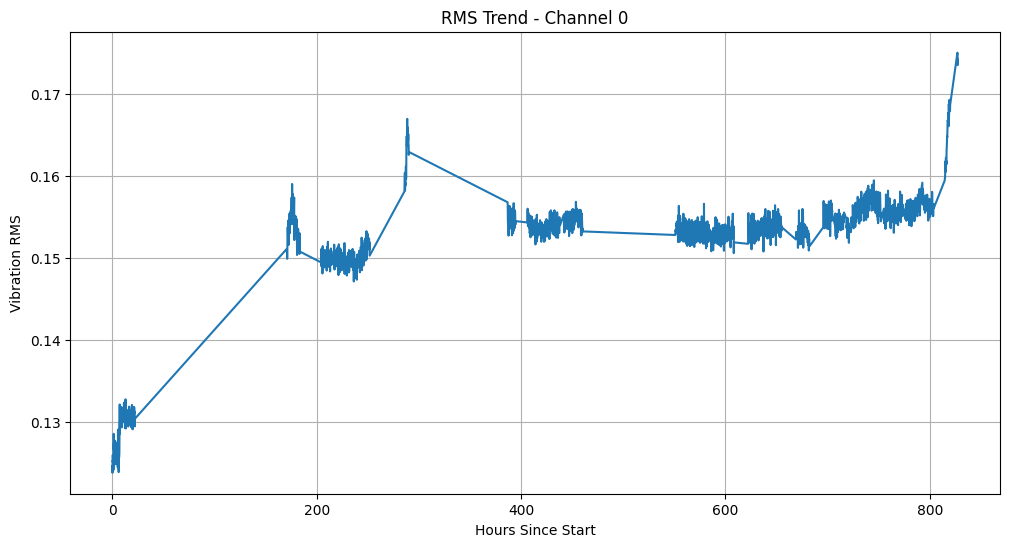

In [18]:
import matplotlib.pyplot as plt # Visualizing future trends

plt.figure(figsize=(12, 6))
plt.plot(df['hours_since_start'], [f[0]['rms'] for f in df['features']])
plt.title('RMS Trend - Channel 0')
plt.ylabel('Vibration RMS')
plt.xlabel('Hours Since Start')
plt.grid(True)
plt.show()


In [22]:
total_files = len(df) #RUL labeling
df['rul'] = total_files - np.arange(total_files)  # Remaining files until failure


In [26]:
# Convert dictionary features to numerical array
feature_names = ['rms', 'kurtosis', 'peak', 'crest_factor', 'skewness']
num_channels = 8  # For 1st_test dataset

# Create empty feature matrix
features_matrix = np.zeros((len(all_features), num_channels * len(feature_names)))

# Populate the matrix
for i, file_features in enumerate(all_features):
    for ch in range(num_channels):
        for j, feat_name in enumerate(feature_names):
            col_index = ch * len(feature_names) + j
            features_matrix[i, col_index] = file_features[ch][feat_name]


In [27]:
from sklearn.ensemble import IsolationForest #training anomaly detection model for 20% data of the model

# Use first 300 files as healthy data (≈20% of 2156 files)
early_data = features_matrix[:300]

# Train model
ad_model = IsolationForest(contamination=0.01, random_state=42)
ad_model.fit(early_data)

# Get anomaly scores (-1 = anomaly, 1 = normal)
anomaly_scores = ad_model.predict(features_matrix)


In [28]:
from sklearn.ensemble import GradientBoostingRegressor #Train RUL prediction model

# Train RUL model
rul_model = GradientBoostingRegressor(random_state=42)
rul_model.fit(features_matrix, df['rul'])

# Predict RUL
rul_predictions = rul_model.predict(features_matrix)


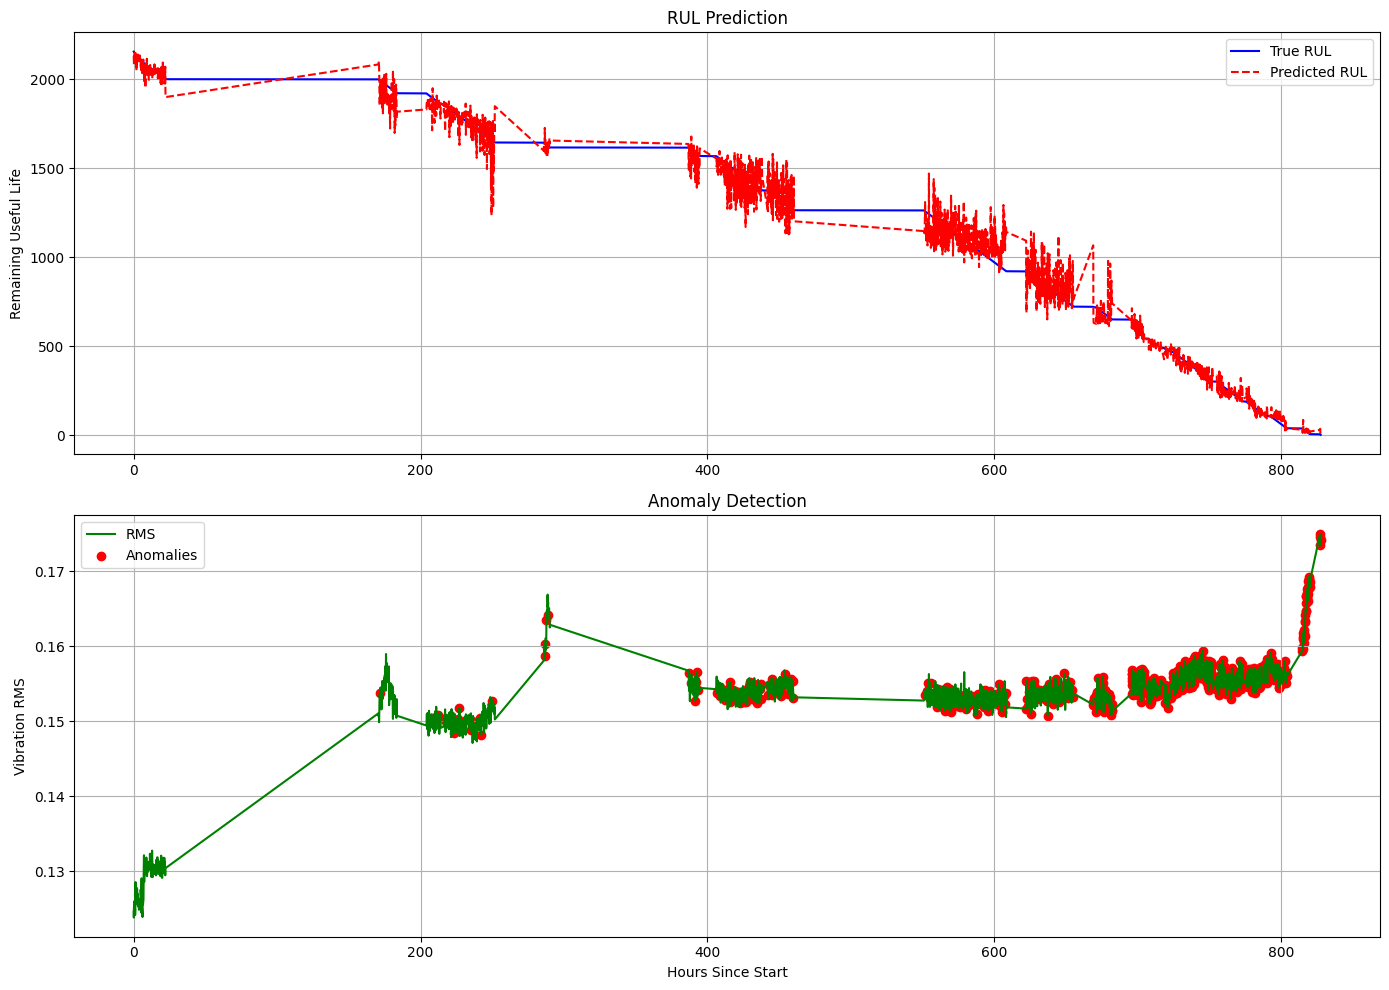

In [29]:
import matplotlib.pyplot as plt # Visualizing results

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot RUL predictions
ax1.plot(df['hours_since_start'], df['rul'], 'b-', label='True RUL')
ax1.plot(df['hours_since_start'], rul_predictions, 'r--', label='Predicted RUL')
ax1.set_ylabel('Remaining Useful Life')
ax1.set_title('RUL Prediction')
ax1.legend()
ax1.grid(True)

# Plot anomaly detection
ax2.plot(df['hours_since_start'], [f[0]['rms'] for f in df['features']], 'g-', label='RMS')
ax2.scatter(
    df.loc[anomaly_scores == -1, 'hours_since_start'],
    [f[0]['rms'] for f in df.loc[anomaly_scores == -1, 'features']],
    color='red', label='Anomalies'
)
ax2.set_xlabel('Hours Since Start')
ax2.set_ylabel('Vibration RMS')
ax2.set_title('Anomaly Detection')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [31]:
from sklearn.metrics import mean_squared_error, f1_score  #evaluating results

# RUL evaluation
rmse = np.sqrt(mean_squared_error(df['rul'], rul_predictions))
print(f"RUL Prediction RMSE: {rmse:.2f} cycles")

# Anomaly detection evaluation (assuming last 10% are true anomalies)
true_anomalies = np.zeros(len(df))
true_anomalies[-200:] = 1  # Last 200 files as anomalies
f1 = f1_score(true_anomalies, anomaly_scores == -1)
print(f"Anomaly Detection F1 Score: {f1:.4f}")


RUL Prediction RMSE: 74.47 cycles
Anomaly Detection F1 Score: 0.3404


In [1]:
# 5. TRAINING PIPELINE --------------------------------------------------------
def main():
    # Configuration (Update with your path)
    folder = r"C:\Users\revan\OneDrive\Desktop\IMS_dataset\1st_test"
    files = sorted(os.listdir(folder))[:1000]  # Use subset for testing
    
    # Create fused dataset
    hc_feats, raw_feats, rul_labels = create_feature_fusion_dataset(files, folder)
    
    # Normalize handcrafted features
    scaler = MinMaxScaler()
    hc_feats = scaler.fit_transform(hc_feats)
    
    # Train/Test split
    split_idx = int(0.8 * len(hc_feats))
    train_hc, test_hc = hc_feats[:split_idx], hc_feats[split_idx:]
    train_raw, test_raw = raw_feats[:split_idx], raw_feats[split_idx:]
    train_rul, test_rul = rul_labels[:split_idx], rul_labels[split_idx:]
    
    # Train RUL model
    fusion_model = create_fusion_model(train_hc.shape[1], (train_raw.shape[1], 1))
    fusion_model.compile(optimizer='adam', loss='mse')
    fusion_model.fit(
        [train_hc, train_raw], train_rul,
        epochs=50, batch_size=128,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=5)]
    )
    
    # Train Anomaly Detection (Autoencoder)
    autoencoder = create_autoencoder(train_hc.shape[1])
    autoencoder.fit(
        train_hc, train_hc,
        epochs=100, batch_size=128,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=10)]
    )
    

In [2]:
# 6. EVALUATION -----------------------------------------------------------
    # RUL Evaluation
    test_pred = fusion_model.predict([test_hc, test_raw])
    rmse = np.sqrt(np.mean((test_pred.flatten() - test_rul)**2))
    print(f"RUL Prediction RMSE: {rmse:.2f}")
    
    # Anomaly Detection
    reconstructions = autoencoder.predict(test_hc)
    mse = np.mean(np.power(test_hc - reconstructions, 2), axis=1)
    threshold = np.percentile(mse, 95)  # Top 5% as anomalies
    
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(test_rul, label='True RUL')
    plt.plot(test_pred, '--', label='Predicted RUL')
    plt.title(f'RUL Prediction (RMSE: {rmse:.2f})')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.plot(mse, label='Reconstruction Error')
    plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
    plt.title('Autoencoder Anomaly Detection')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

IndentationError: unexpected indent (3316061385.py, line 3)